# Import all the packages used

In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

%matplotlib inline
import vampnet
from vampnet import data_generator as vamp_data_loader
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Flatten,
    Input,
    BatchNormalization,
    concatenate,
)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.gridspec as gridspec
from tensorflow.keras.backend import clear_session
from msmbuilder.dataset import dataset
from sklearn.utils import check_random_state
import random
import os

%load_ext autoreload
%autoreload 2

# Define Hyperparameters

In [2]:
# Tau, how much is the timeshift of the two datasets
tau = 10

# Batch size for Stochastic Gradient descent
batch_size = 1000

# Which trajectory points percentage is used as training
train_ratio = 0.9

# (not used) How many hidden layers the network has
network_depth = 1

# (not used) Width of every layer
layer_width = 100

# Learning rate used for the ADAM optimizer
learning_rate = 1e-4

# How many output states the network has
output_size = 30

# Iteration over the training set in the fitting process
nb_epoch = 60

epsilon = 1e-5

# Initialized the VAMPnets wrapper class

In [3]:
vamp = vampnet.VampnetTools(epsilon=epsilon)

# Load Data

In [4]:
ds = dataset("../../src_*/small_traj*/src*cat.dcd", topology="../system_xy_small.pdb")

# Featurization

In [5]:
# IMAT fragments
imat_frags = []
imat_frags.append(ds[0].topology.select("resname IMAT and name C4 C5 C6 N7 C8 C9 C10"))
imat_frags.append(
    ds[0].topology.select("resname IMAT and name N1 C2 N3 C4 C11 C12 N13")
)
imat_frags.append(
    ds[0].topology.select("resname IMAT and name N13 C14 C15 C16 C17 C18 C19")
)
imat_frags.append(ds[0].topology.select("resname IMAT and name C20 N22 C24 O25 C26"))
imat_frags.append(
    ds[0].topology.select("resname IMAT and name C26 C27 C28 C29 C30 C31 C32")
)
imat_frags.append(
    ds[0].topology.select("resname IMAT and name C32 N33 C34 N36 C37 C38 C39")
)

In [6]:
def featurize_traj(traj, imat_frags=None):
    featurized = np.zeros((traj.n_frames, 0))

    for frag in imat_frags:
        for residue in traj.topology.residues:
            if not residue.is_protein:
                break
            res_indices = [
                atom.index for atom in residue.atoms if atom.element.atomic_number > 1
            ]
            atom_pairs = []
            for i in frag:
                for j in res_indices:
                    atom_pairs.append([i, j])
            dist = 1 / np.amin(md.compute_distances(traj, atom_pairs), axis=1)
            featurized = np.column_stack((featurized, dist))
    return featurized

In [8]:
out_dataset = ds.create_derived("vampnet_featurized", fmt="dir-npy")

for key in ds.keys():
    print(".", end="")
    trajectory = []
    for i, chunk in enumerate(ds.iterload(key, chunk=10000)):
        trajectory.append(featurize_traj(chunk, imat_frags))
    out_dataset[key] = np.concatenate(trajectory)
out_dataset.close()

..............................................................................................................................................................................................................................................................................

In [7]:
full_featurization = dataset("vampnet_featurized/")

# Prepare Featurization for VAMPnet

In [10]:
# First time setup, flatten data into two trajectories separated by lagtime (transitions)
featurization_ord = np.concatenate([traj[:-tau] for traj in full_featurization])
np.save("featurization_ord", featurization_ord)

featurization_ord_lag = np.concatenate([traj[tau:] for traj in full_featurization])
np.save("featurization_ord_lag", featurization_ord_lag)

In [8]:
featurization_ord = np.load("featurization_ord.npy", mmap_mode="r")
featurization_ord_lag = np.load("featurization_ord_lag.npy", mmap_mode="r")

In [12]:
# Shuffle data keeping transitions paired
indexes = np.arange(len(featurization_ord))
np.random.shuffle(indexes)
# slice that can be used to unshuffle data, and eventually reconstruct trajectories
# shouldn't need this, can just train on unshuffled data
# np.save("unshuffle",np.argsort(indexes))

featurization = featurization_ord[indexes]
np.save("featurization", featurization)

featurization_lag = featurization_ord_lag[indexes]
np.save("featurization_lag", featurization_lag)

In [9]:
featurization = np.load("featurization.npy", mmap_mode="r")
featurization_lag = np.load("featurization_lag.npy", mmap_mode="r")

In [10]:
# from Abl paper: 10% of the data (highly correlated to the training data) was selected for cross-validation.
# Since the sampling of conformational space is so sparse, no independent data can be held out from analysis
# for cross-validation. Even if, the held out data would be so different form the rest,that it would never
# confirm the model that was trained on the rest. To do at least some minimal cross-validation, we split the
# data into two highly correlated sets: a) every tenth frame, starting to count at the zeroth frame b) every
# 10th frame, starting to count at the fifth frame. Set (a) is used for training while set (b) is used for
# this “fig leaf” cross-validation.
train_length = int(len(featurization) * train_ratio)
valid_length = len(featurization) - train_length

train_data = featurization[:train_length]
valid_data = featurization[train_length:]

train_data_lag = featurization_lag[:train_length]
valid_data_lag = featurization_lag[train_length:]

input_size = featurization.shape[1]

# Run several model iterations saving the best one, to help finding sparcely populated states

In [11]:
output_size = 30
Y_train = np.zeros((train_length, 2 * output_size)).astype("float32")
Y_vali = np.zeros((valid_length, 2 * output_size)).astype("float32")

In [12]:
max_vm = 0
attempts_number = 10


# IMPORTANT: the function vamp.loss_VAMP2_autograd can only be used with tensorflow 1.6 or more recent.
# For older versions of TF, use the function vamp.loss_VAMP2

losses = [
    vamp.loss_VAMP2_autograd,
]


for attempt in range(attempts_number):

    # Clear the previous tensorflow session to prevent memory leaks
    clear_session()

    # Build the model

    # nodes = [layer_width]*network_depth

    Data_X = Input(shape=(input_size,))
    Data_Y = Input(shape=(input_size,))

    # Add a softmax output layer.
    # Should be replaced with a linear activation layer if
    # the outputs of the network cannot be interpreted as states
    softmax = Dense(output_size, activation="softmax")

    lx_branch = softmax(Data_X)
    rx_branch = softmax(Data_Y)

    # Merge both networks to train both at the same time
    merged = concatenate([lx_branch, rx_branch])

    # Initialize the model and the optimizer, and compile it with
    # the loss and metric functions from the VAMPnets package
    model = Model(inputs=[Data_X, Data_Y], outputs=merged)
    adam = Adam(lr=learning_rate)

    vm1 = np.zeros((len(losses), nb_epoch))
    tm1 = np.zeros_like(vm1)
    vm2 = np.zeros_like(vm1)
    tm2 = np.zeros_like(vm1)

    for l_index, loss_function in enumerate(losses):

        model.compile(
            optimizer=adam,
            loss=loss_function,
            metrics=[
                vamp.metric_VAMP,
                vamp.metric_VAMP2,
            ],
        )

        # Train the model
        hist = model.fit(
            [train_data, train_data_lag],
            Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=([valid_data, valid_data_lag], Y_vali),
            verbose=0,
        )

        vm1[l_index] = np.array(hist.history["val_metric_VAMP"])
        tm1[l_index] = np.array(hist.history["metric_VAMP"])

        vm2[l_index] = np.array(hist.history["val_metric_VAMP2"])
        tm2[l_index] = np.array(hist.history["metric_VAMP2"])

    vm1 = np.reshape(vm1, (-1))
    tm1 = np.reshape(tm1, (-1))
    vm2 = np.reshape(vm2, (-1))
    tm2 = np.reshape(tm2, (-1))

    # Average the score obtained in the last part of the training process
    # in order to estabilish which model is better and thus worth saving

    score = vm1[-5:].mean()
    t_score = tm1[-5:].mean()
    extra_msg = ""
    if score > max_vm:
        extra_msg = " - Highest"
        best_weights = model.get_weights()
        max_vm = score
        vm1_max = vm1
        tm1_max = tm1
        vm2_max = vm2
        tm2_max = tm2

    print(
        "Attempt {0}, training score: {1:.2f}, validation score: {2:.2f}".format(
            attempt + 1, t_score, score
        )
        + extra_msg
    )

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Attempt 1, training score: 28.87, validation score: 28.73 - Highest
Attempt 2, training score: 28.82, validation score: 28.62
Attempt 3, training score: 28.74, validation score: 28.64


In [15]:
model.save("vampnet_model/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vampnet_model/assets


In [ ]:
# load a saved model, need to reconnect custom object names for some reason (might differ with tensorflow version?)
custom_objects = {
    "loss_VAMP2_autograd": vamp.loss_VAMP2_autograd,
    "metric_VAMP": vamp.metric_VAMP,
    "metric_VAMP2": vamp.metric_VAMP2,
}

model = tf.keras.models.load_model(
    "VAMPnet_CA_inverse_50", custom_objects=custom_objects
)

# Recover the saved model and its training history

In [13]:
model.set_weights(best_weights)

tm1 = np.array(vm1_max)
tm2 = np.array(tm1_max)
vm1 = np.array(vm2_max)
vm2 = np.array(tm2_max)

# Training result visualization

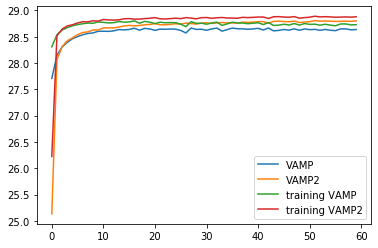

In [14]:
plt.plot(vm1, label="VAMP")
plt.plot(vm2, label="VAMP2")
plt.plot(tm1, label="training VAMP")
plt.plot(tm2, label="training VAMP2")
plt.legend()
plt.show()

In [16]:
# recalculate output_size from loaded model
output_size = model.output_shape[1] // 2

# Transform the input trajectory using the network

states_prob_all = model.predict([featurization_ord, featurization_ord_lag])
states_prob_t = states_prob_all[:, :output_size]
states_prob_lag = states_prob_all[:, output_size:]

# reorganize the output of the network in order to have every data point transformed by the network in one array
start = 0
traj_lengths = np.asarray([len(traj) for traj in full_featurization])
states_prob = np.zeros((states_prob_t.shape[0] + len(traj_lengths) * tau, output_size))
# reconstructs trajectories from states_prob_t except for last tau steps which are from states_prob_lag
for l, length_i in enumerate(traj_lengths - tau):
    states_prob[start + l * tau : start + l * tau + length_i] = states_prob_t[
        start : start + length_i
    ]
    states_prob[
        start + l * tau + length_i : start + l * tau + length_i + tau
    ] = states_prob_lag[start + length_i - tau : start + length_i]
    start += length_i

# Order the output states based on their population
# coor_pred = np.argmax(states_prob, axis = 1)
# discard low prob (< 60%) assignments, (removes fuzzy states, reduces transitions)
coor_pred = np.where(
    np.amax(states_prob, axis=1) > 0.6, np.argmax(states_prob, axis=1), -1
)
print(
    "unassigned frames = "
    + str(round(len(np.where(coor_pred == -1)[0]) / len(states_prob) * 100, 1))
    + "%"
)
indexes = [
    np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n))
    for n in range(output_size)
]
states_num = [len(i[0]) for i in indexes]
states_order = np.argsort(states_num).astype("int")[::-1]

pred_ord = states_prob[:, states_order]

unassigned frames = 4.0%


In [17]:
# reconstruct featurized trajectories
traj_lengths = np.asarray([len(traj) for traj in full_featurization])
traj_list = []
start = 0
for length_i in traj_lengths:
    traj_list.append(pred_ord[start : start + length_i])
    start += length_i

In [ ]:
# reconstruct labelled trajectories
labelled = []
start = 0
for length_i in traj_lengths:
    labelled.append(coor_pred[start : start + length_i])
    start += length_i

# Predict pull sims

In [ ]:
ds_pull = dataset(
    "/home/trayder/abl_data/src_400ns_pull/src*.dcd",
    topology="/home/trayder/abl_data/src_pull.pdb",
)

In [ ]:
out_dataset = ds.create_derived("pull_featurized", fmt="dir-npy")

for key in ds_pull.keys():
    trajectory = []
    for i, chunk in enumerate(ds_pull.iterload(key, chunk=100)):
        trajectory.append(featurize_traj(chunk, imat_frags))
    out_dataset[key] = np.concatenate(trajectory)
out_dataset.close()

In [ ]:
pull_featurized = dataset("pull_featurized/")

In [ ]:
pull_state_traj = np.zeros((0, len(pull_featurized[0])))
for traj in pull_featurized:
    pull_state_traj = np.vstack(
        (pull_state_traj, np.argmax(model.predict([traj, traj]), axis=1))
    )

In [ ]:
pull_state_traj

In [ ]:
for i in range(len(pull_state_traj)):
    indexes = np.unique(pull_state_traj[i], return_index=True)[1]
    states_visited = np.asarray(
        [pull_state_traj[i][index] for index in sorted(indexes)], dtype=int
    )
    print(states_visited)

# Visualize the population of the states

In [ ]:
# Xtal structure state:
xtal_traj = md.load("../system_xy_small.pdb")
xtal_feat = featurize_traj(
    xtal_traj, imat_frags=src_imat_frags, cleft_residues=src_cleft_residues
)
xtal_state = np.argmax(model.predict([xtal_feat, xtal_feat])[0][output_size:])
print(xtal_state)

In [ ]:
n_frames = len(coor_pred)
state_pops = np.round(np.asarray(states_num) / n_frames * 100, 1)
for i in np.argsort(states_num)[::-1]:
    print(i, states_num[i], str(round(states_num[i] / n_frames * 100, 1)) + "%")

# Draw states

In [ ]:
def draw_samples(labelled, n_samples, chosen_states="all", n_states=None):
    """Sample conformations from each state. Samples are randomly selected to be
    closer to the cluster center than the mean of the distribution

    Parameters
    ----------
    clustering : Object
        should have property clustering.labels_ which corresponds
        to the cluster assignment of every frame

    n_samples : int
        How many samples to return from each state

    Returns
    -------
    selected_pairs_by_state : np.array, dtype=int, shape=(n_states, n_samples, 2)
        selected_pairs_by_state[state] gives an array of randomly selected (trj, frame)
        pairs from the specified state.

    See Also
    --------
    utils.map_drawn_samples : Extract conformations from MD trajectories by index.

    """
    sequences = labelled
    random = check_random_state(None)

    # n_states = max(map(lambda x: max(x), sequences)) + 1
    # n_states_2 = len(np.unique(np.concatenate(sequences)))
    # if any(-1 in traj for traj in sequences):
    #    n_states_2 -= 1
    # assert n_states == n_states_2, "Must have non-empty, zero-indexed, consecutive states: found %d states and %d unique states." % (n_states, n_states_2)

    if chosen_states == "all":
        chosen_states = range(n_states)
    #         chosen_states = np.unique(np.concatenate(labelled))
    #         chosen_states = np.delete(chosen_states, np.where(chosen_states==-1))

    selected_pairs_by_state = []
    for state in chosen_states:
        all_frames = [np.where(a == state)[0] for a in sequences]
        if len(np.concatenate(all_frames)) < n_samples:
            if len(concatenate(all_frames)) == 0:
                print("WARNING: State " + str(state) + " is empty: Skipping")
                selected_pairs_by_state.append(np.asarray([(-1, -1)] * n_samples))
                continue
            print("WARNING: Only " + str(len(all_frames)) + " in state " + str(state))
        pairs = [
            (trj, frame) for (trj, frames) in enumerate(all_frames) for frame in frames
        ]
        selected_pairs_by_state.append(
            [pairs[random.choice(len(pairs))] for i in range(n_samples)]
        )

    return np.array(selected_pairs_by_state)

In [ ]:
def output_data(selected_pairs_by_state, file_path=None, ds=None):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    for state, samples in enumerate(selected_pairs_by_state):
        print("\n" + str(state), end=" | ")
        samples = selected_pairs_by_state[state]
        if -1 in samples:
            print("\n" + str(state) + " | Empty", end="")
            continue
        print("\n" + str(state), end=" | ")

        traj = None

        for pair_num, pair in enumerate(samples):
            print(pair_num, end=" ")
            traj_num, frame = pair
            traj_num = traj_num
            try:
                traj = traj.join(ds.get(traj_num)[frame])
            except:
                traj = ds.get(traj_num)[frame]
        filename = str(file_path) + "/State" + str(state) + ".dcd"
        traj.save_dcd(filename)

In [ ]:
selected_pairs_by_state = draw_samples(labelled, 10, n_states=output_size)
print(selected_pairs_by_state.shape)

In [ ]:
output_data(selected_pairs_by_state, file_path="30_states", ds=ds)

# Markov Model Estimation

## Prepare multiple trajectories  

In [ ]:
# raw transition counts matrix
counts_matrix = np.zeros((output_size, output_size), dtype=int)
for traj in labelled:
    for i in range(len(traj[:-1])):
        if -1 in [traj[i], traj[i + 1]]:
            continue
        counts_matrix[traj[i], traj[i + 1]] += 1

# symmetric binary connectivity matrix
binary_matrix = np.zeros_like(counts_matrix, dtype=int)
for i, j in zip(np.where(counts_matrix != 0)[0], np.where(counts_matrix != 0)[1]):
    binary_matrix[i, j] = 1
    binary_matrix[j, i] = 1

# transition probability matrix
trans_matrix = np.zeros((0, len(counts_matrix)))
for row in counts_matrix:
    trans_matrix = np.vstack((trans_matrix, row / np.sum(row)))

In [ ]:
def advanced_mfpt(transmat, start_state=None, sink_states=None, n_iter=100, lag_time=1):
    """Simulates movement through the transition matrix and returns a list of first passage times
    between start_state (int) and sink_states (list) for calculating mean, median and distribution
    of first passage times
    mfpt is calculated in time units of the transmat, it is returned multiplied by lag_time,
    choose a number that will scale to your desired units
    With sufficient iterations will result in same mfpt as calculated from transition path theory

    Returns:
    list of first passage times

    Can easily be modded to return a list of transitions, for movie making etc.
    """

    transprob = transmat.copy()
    # create a copy of transmat with cumulative probabilities for the transitions out of each state
    # to enable use of np.searchsorted to randomly select transitions
    for i, state in enumerate(transmat):
        for j, transition in enumerate(state):
            transprob[i, j] = np.sum(transmat[i, : j + 1])
    nstep_list = []
    for i in range(n_iter):
        state = start_state
        nsteps = 0
        while state not in sink_states:
            nsteps += 1
            random_number = random.random()
            new_state = np.searchsorted(transprob[state], random_number)
            #     if (new_state != state):
            #         print(new_state)
            state = new_state
            if nsteps > 10000:
                nsteps = -1
                break
        nstep_list.append(nsteps)
    return np.asarray(nstep_list) * lag_time

In [ ]:
for start_state in range(len(trans_matrix)):
    states_list = list(range(len(trans_matrix)))
    states_list.pop(start_state)
    nstep_list = advanced_mfpt(
        trans_matrix,
        start_state=start_state,
        sink_states=states_list,
        lag_time=tau,
        n_iter=100,
    )
    print(start_state, np.mean(nstep_list), np.median(nstep_list))

In [ ]:
start_state = 3
states_list = list(range(len(trans_matrix)))
states_list.pop(start_state)
nstep_list = advanced_mfpt(
    trans_matrix,
    start_state=start_state,
    sink_states=states_list,
    lag_time=1,
    n_iter=1000,
)
print(np.median(nstep_list))
print(np.mean(nstep_list))
plt.hist(np.asarray(nstep_list))

In [ ]:
# states i,j forward/reverse transitions
print("i\tj\tfwd\trev\n----------------------------")
for i, j in zip(np.where(counts_matrix != 0)[0], np.where(counts_matrix != 0)[1]):
    if j == i:
        continue
    print(i, "\t", j, "\t", counts_matrix[i, j], "\t", counts_matrix[j, i])

In [ ]:
# number of connected state, per state
hub_scores = np.sum(binary_matrix, axis=1) - 1
for state, score in zip(np.argsort(hub_scores)[::-1], np.sort(hub_scores)[::-1]):
    print(state, score)

In [ ]:
# Calculate independent networks
state_nums = list(range(output_size))
all_networks = []
checked_states = []
while state_nums:
    this_network = []
    state = state_nums.pop()
    if state in checked_states:
        continue
    check_states = [state]
    while check_states:
        check_state = check_states.pop()
        if check_state in checked_states:
            continue
        this_network.append(check_state)
        checked_states.append(check_state)
        check_states = check_states + list(np.where(binary_matrix[check_state])[0])

    all_networks.append(this_network)
for network in all_networks:
    print(network)

In [ ]:
def calc_transmin(counts_matrix, n_results=None):
    """Calculates the number of transitions into and out of each state
    returns the lower number (in vs out) for each state
    Effectively identifies poor connectivity on an individual state basis"""
    n_states = len(counts_matrix)
    if not n_results:
        n_results = n_states
    trans_min = np.zeros(n_states)
    for state in range(n_states):
        trans_self = counts_matrix[state, state]
        trans_out = np.sum(counts_matrix[state, :]) - trans_self
        trans_in = np.sum(counts_matrix[:, state]) - trans_self
        trans_min[state] = min(trans_out, trans_in)

    return trans_min

In [ ]:
trans_min = calc_transmin(counts_matrix)
for state in trans_min.argsort():
    print(
        "State  "
        + str(state)
        + "\tpopulation:  "
        + str(states_num[state])
        + "\t transmin: "
        + str(trans_min[state])
    )

In [ ]:
def join_clusters(counts_matrix, final_clusters=None, populations=None):
    """
    Finds the highest minimum value between forward and backward transitions...
    Merges most connected pairs of states together and reports
    the <final_clusters> least connected states using hard to read code

    Don't screw with this, you'll fuck it up for sure. Learn about the
    difference between copying and assigning matrices and develop a test
    case you can calculate by hand

    Also note that due to discretization error, there is a bias towards joining
    clusters into the largest blob rather than forming multiple aggregates.
    This bias only really emerges after the largest connectivity issues are fixed
    """

    counts_matrix = counts_matrix.copy()
    diagonal = np.diagonal(counts_matrix).copy()
    np.fill_diagonal(counts_matrix, 0)
    min_matrix = counts_matrix.copy()

    cluster_record = [[i] for i in range(counts_matrix.shape[0])]
    n_clusters = counts_matrix.shape[0]

    while n_clusters > final_clusters:

        for i in range(len(min_matrix)):
            for j in range(i + 1, len(min_matrix)):
                min_matrix[i, j] = min(counts_matrix[i, j], counts_matrix[j, i])
                min_matrix[j, i] = min_matrix[i, j]

        x = np.argmax(min_matrix) // min_matrix.shape[0]
        y = np.argmax(min_matrix) - x * min_matrix.shape[0]

        # print("merging "+str(y)+" into "+str(x))

        counts_matrix[x] = counts_matrix[x] + counts_matrix[y]
        counts_matrix[y] = counts_matrix[y] * 0
        counts_matrix[:, x] = counts_matrix[:, x] + counts_matrix[:, y]
        counts_matrix[:, y] = counts_matrix[:, y] * 0

        diagonal = diagonal + np.diagonal(counts_matrix)
        diagonal[x] = diagonal[x] + diagonal[y]
        diagonal[y] = 0
        np.fill_diagonal(counts_matrix, 0)

        cluster_record[x] = cluster_record[x] + cluster_record[y]
        cluster_record[y] = [-1]

        n_clusters -= 1

        print("*LUMP*")
        for i in cluster_record:
            if (i != [-1]) & (len(i) > 1):
                print(i)

    for i in range(len(diagonal)):
        counts_matrix[i, i] = diagonal[i]

    for i in reversed(range(len(cluster_record))):
        if cluster_record[i] == [-1]:
            counts_matrix = np.delete(counts_matrix, i, 0)
            counts_matrix = np.delete(counts_matrix, i, 1)
            cluster_record = np.delete(cluster_record, i)

    reduced_matrix = counts_matrix

    return reduced_matrix, cluster_record

In [ ]:
def find_gateways(counts_matrix, cluster_record):
    """Identifies the state in each lump that is most connected to the largest cluster"""
    # everything except the largest cluster is a bad_lump
    bad_lumps = cluster_record[
        np.asarray(
            [len(cluster_record[i]) for i in range(len(cluster_record))]
        ).argsort()
    ][:-1]
    chosen_states = np.asarray([], dtype=int)
    for lump in bad_lumps:
        transmax = 0
        for cluster in lump:
            transmat = counts_matrix.copy()
            for cluster2 in lump:
                transmat[cluster][cluster2] = 0
            if np.amax(transmat[cluster]) >= transmax:
                transmax = np.amax(transmat[cluster])
                gateway = cluster
        chosen_states = np.append(chosen_states, gateway)

    return chosen_states

In [ ]:
reduced_matrix, cluster_record = join_clusters(counts_matrix, 1)

In [ ]:
for i in cluster_record:
    print(i)

In [ ]:
chosen_states_connect = find_gateways(counts_matrix, cluster_record)
chosen_states_connect

# Estimate the implied timescales

In [ ]:
max_tau = 20
lag = np.arange(1, max_tau, 1)
its = vamp.get_its(traj_list, lag)
vamp.plot_its(its, lag)

In [ ]:
plt.plot(lag, its.T[:, ::-1]);

# Chapman-Kolmogorov test for the estimated koopman operator

In [ ]:
steps = 8
tau_msm = 35
predicted, estimated = vamp.get_ck_test(traj_list, steps, tau_msm)
vamp.plot_ck_test(predicted, estimated, output_size, steps, tau_msm)

In [ ]:
n_states = output_size
steps = 10
tau_msm = 1
pred, est = vamp.get_ck_test(traj_list, steps, tau_msm)

In [ ]:
plt.rcParams["figure.dpi"] = 436
ncols = 6
nplots = n_states ** 2
nrows = int(nplots / ncols)
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6, 1 * nrows))
plotnum = 0
for i in range(n_states):
    for j in range(n_states):
        index_j = plotnum % ncols
        index_i = int(plotnum / ncols)
        ax[index_i][index_j].plot(range(0, steps * tau, tau), pred[i, j], color="b")

        ax[index_i][index_j].plot(
            range(0, steps * tau, tau), est[i, j], color="r", linestyle="--"
        )

        ax[index_i][index_j].set_title(str(i + 1) + "->" + str(j + 1), fontsize="small")
        plotnum += 1

ax[0][0].set_ylim((-0.1, 1.1))
ax[0][0].set_xlim((0, steps * tau))
ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps * tau, 3)))
plt.show()

# Hbonds

In [ ]:
# WIP, currently very memory inefficient

In [ ]:
def calc_hbonds(
    traj,
    freq=None,
    ligresname="",
    occupancy_type="binary",
    periodic=True,
    distance_cutoff=0.25,
    angle_cutoff=2.0 * np.pi / 3.0,
):
    """
    Calculates angles and distances for all donor-acceptor pairs then returns the
    occupancy for a reduced set of hydrogen bonds depending on given criteria

    Parameters
    ----------
    traj : mdtraj trajectory file
    freq : only return hydrogen bonds that exist for longer than this fraction of time
    ligresname : if provided only include hydrogen bonds that include this residue name
        hydrogen bonds are calculated separately based on resid then output as an
        average based on resname
    occupancy_type : if binary, occupancy only incorporates one instance of each
        hydrogen bond per frame, otherwise multiple instances of a hydrogen bond per
        frame will increase the occupancy
    periodic : periodic boundaries are used when calculating angles and distances
    distance_cutoff : distance criteria for determining hydrogen bonds (nm)
    angle_cutoff : angle criteria for determining hydrogen bonds (radians)

    Returns
    -------
    hbond_matrix : 2D array (hbonds,frames), values are the number of each hydrogen bond
        occuring in each frame.
    unique_triplets : Array of triplets (hbonds,3), [donor, hydrogen, acceptor] atom
        indices for the first occurence (by topology) of each unique hydrogen bond
    occupancy : array (hbonds,1), calculated occupancy for each hydrogen bond
    """

    if traj.topology is None:
        raise ValueError("traj must contain topology information")

    def get_donors(e0, e1):
        elems = set((e0, e1))
        bonditer = traj.topology.bonds
        atoms = [
            (b[0], b[1])
            for b in bonditer
            if set((b[0].element.symbol, b[1].element.symbol)) == elems
        ]

        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    nh_donors = get_donors("N", "H")
    oh_donors = get_donors("O", "H")
    xh_donors = np.asarray(list(nh_donors) + list(oh_donors))

    assert len(xh_donors) > 0, "No hydrogens found"

    acceptors = [
        a.index
        for a in traj.topology.atoms
        if a.element.symbol == "O" or a.element.symbol == "N"
    ]

    angle_triplets = np.array(
        [(e[0][0], e[0][1], e[1]) for e in product(xh_donors, acceptors)]
    )

    # filter angle triplets to only those involving the ligand (based on provided ligand resname)
    if ligresname:
        lig_triplets = np.zeros((0, 3), dtype=int)
        for triplet in angle_triplets:
            if np.in1d(
                np.asarray([traj.topology.atom(i).residue.name for i in triplet]),
                ligresname,
            ).any():
                lig_triplets = np.vstack((lig_triplets, triplet))
        angle_triplets = lig_triplets
    distance_pairs = angle_triplets[:, [1, 2]]  # possible H..acceptor pairs

    angles = md.compute_angles(traj, angle_triplets, periodic=periodic)
    distances = md.compute_distances(traj, distance_pairs, periodic=periodic)

    mask = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    mask = np.where(mask, 1, 0)

    # convert triplets to unique names
    def convert_to_name(index, ligresname=ligresname):
        resname = traj.topology.atom(int(index)).residue.name
        resid = str(traj.topology.atom(int(index)).residue.resSeq)
        atomname = traj.topology.atom(int(index)).name
        # allows for multiple ligand residues of the same name (e.g. polysaccharides)
        name = resname + resid + "-" + atomname + " "
        return name

    convert_to_name = np.vectorize(convert_to_name)
    triplet_names = [i + j + k for i, j, k in convert_to_name(angle_triplets)]

    # reduce to unique names
    unique_triplet_names, mapping = np.unique(triplet_names, return_inverse=True)
    n_unique_triplets = len(unique_triplet_names)

    # collapse all duplicate bonds into hbond_matrix, record first instance of hbonds as unique_triplets
    hbond_matrix = np.zeros((0, mask.shape[0]), dtype=int)
    unique_triplets = np.zeros((0, 3), dtype=int)
    for index in range(n_unique_triplets):
        hbond_matrix = np.vstack(
            (hbond_matrix, np.sum(mask[:, np.where(mapping == index)[0]], axis=1))
        )
        unique_triplets = np.vstack(
            (unique_triplets, angle_triplets[np.where(mapping == index)[0][0]])
        )

    # Update names and mapping after collapse
    triplet_names = [i + j + k for i, j, k in convert_to_name(unique_triplets)]
    unique_triplet_names, mapping = np.unique(triplet_names, return_inverse=True)

    # calculate occupancy
    if occupancy_type == "binary":
        binary_matrix = np.where(hbond_matrix, 1, 0)
        occupancy = np.sum(binary_matrix, axis=1) / float(binary_matrix.shape[1])
    else:
        occupancy = np.sum(hbond_matrix, axis=1) / float(hbond_matrix.shape[1])

    redundants = np.asarray([])
    for index in range(n_unique_triplets):
        dup_list = np.where(mapping == index)[0]
        occupancy[dup_list[0]] = np.average(occupancy[dup_list])
        redundants = np.concatenate((redundants, dup_list[1:]))

    occupancy = np.delete(occupancy, redundants)
    hbond_matrix = np.delete(hbond_matrix, redundants, 0)
    unique_triplets = np.delete(unique_triplets, redundants, 0)

    # Obliterate low frequency bonds
    if freq:
        hbond_matrix = np.delete(hbond_matrix, np.where(occupancy < freq), 0)
        unique_triplets = np.delete(unique_triplets, np.where(occupancy < freq), 0)
        occupancy = np.delete(occupancy, np.where(occupancy < freq), 0)

    return hbond_matrix, unique_triplets, occupancy

In [ ]:
hbond_matrix, unique_triplets, occupancy = calc_hbonds(
    traj,
    freq=0.1,
    ligresname="IMAT",
    distance_cutoff=0.3,
    angle_cutoff=100 / 180 * np.pi,
)

In [ ]:
"""
format of Hbond printout
"""
# label = lambda hbond : '%s -- %s -- %s\t' % (traj.topology.atom(hbond[0]), traj.topology.atom(hbond[1]), traj.topology.atom(hbond[2]))
label = lambda hbond: "%s_%s\t" % (
    str(traj.topology.atom(hbond[0]).residue).title()
    + "-"
    + traj.topology.atom(hbond[0]).name,
    str(traj.topology.atom(hbond[2]).residue).title()
    + "-"
    + traj.topology.atom(hbond[2]).name,
)

# OUTFILE=open("20_bac_hbonds.txt", "w")

for i, hbond in enumerate(unique_triplets):
    if occupancy[i] > 0.01:
        line = label(hbond) + "\t" + str(round(occupancy[i], 4) * 100) + "%"
        print(line)
    # OUTFILE.write(line+"\n")

# OUTFILE.close()